# Q. #4

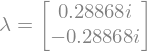

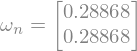

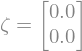

In [1]:
# Import all the functions used in part 1
from era_okid_tools import *
prob = "4-3"
b = 0

# Set seed for consistent results
rng = np.random.default_rng(seed = 100)

# Simulation dimensions
cases = 3 # Number of cases
n = 2 # Number of states
r = 1 # Number of inputs
m = 2 # Number of measurements
t_max = 50 # Total simulation time
dt_sim = 0.1 # Simulation timestep duration
nt_sim = int(t_max/dt_sim) # Number of simulation timesteps
dt_sample = 0.2 # Sample timestep duration
nt_sample = int(t_max/dt_sample) # Number of sample timesteps
interval = int(dt_sample/dt_sim) # Sample index interval

# Simulation time
train_cutoff = int(20/dt_sample) + 1
t_sim = np.linspace(0, t_max, nt_sim + 1)
t_sample = np.linspace(0, t_max, nt_sample + 1)
t_train = t_sample[:train_cutoff]
t_test = t_sample
nt_train = train_cutoff
nt_test = nt_sample

# Problem parameters
theta_0 = 0.5 # Angular velocity
k = 10 # Spring stiffness
mass = 1 # Point mass

# State space model
A_c = np.array([[0, 1], [theta_0**2 - k/mass, 0]])
B_c = np.array([[0], [1]])
C = np.eye(2)
D = np.array([[0], [1]])
A, B = c2d(A_c, B_c, dt_sim)
eig_A = spla.eig(A_c)[0] # Eigenvalues of true system
etch(f"\lambda", eig_A)
etch(f"\omega_{{n}}", np.abs(eig_A))
etch(f"\zeta", -np.cos(np.angle(eig_A)))

# True simulation values
X_0_sim = np.zeros([n, 1]) # Zero initial condition
U_sim = np.zeros([cases, r, nt_sim]) # True input vectors
U_sim[0] = rng.normal(0, 0.1, [r, nt_sim]) # True input for case 1
U_sim[1] = spsg.square(2*np.pi*5*t_sim[:-1]) # True input for case 2
U_sim[2] = np.cos(2*np.pi*2*t_sim[:-1]) # True input for case 3
X_sim = np.zeros([cases, n, nt_sim + 1]) # True state vectors
Z_sim = np.zeros([cases, m, nt_sim]) # True observation vectors

# Sampled simulation values
U_sample = U_sim[:, :, ::interval] # Sampled input vectors
X_sample = np.zeros([cases, n, nt_sample + 1]) # Sampled state vectors
Z_sample = np.zeros([cases, n, nt_sample]) # Sampled observation vectors

# Separation into train and test data
U_train = U_sample[0, :r, :train_cutoff]
U_test = U_sample # Test input vectors
X_test = np.zeros([cases, n, nt_test + 1]) # Test state vectors
Z_test = np.zeros([cases, m, nt_test]) # Test observation vectors

# True Markov parameters
Z_markov = np.zeros_like(Z_sample) # Output recovered from true Markov parameters and input
Y_markov = ss2markov(A, B, C, D, nt = nt_sample) # True Markov parameters

In [2]:
# OKID logistics
order = 10 # Order of OKID algorithm, number of Markov parameters to identify after the zeroeth
alpha, beta = 3, 5 # Number of block rows and columns in Hankel matrices
n_era = 2 # Number of proposed states
X_0_okid = np.zeros([n_era, 1]) # Zero initial condition

print(f"Min. OKID Order: {max([alpha + beta, (n_era/m) + (n_era/r)]):n}")
print(f"Max. OKID Order: {(nt_train - r)/(r + m):n}")
print(f"Proposed OKID Order: {order:n}")

Min. OKID Order: 8
Max. OKID Order: 33.3333
Proposed OKID Order: 10


Note that we have set $l_0 = 10$, $\alpha = 3$, and $\beta = 5$ for this simulation.
We choose the sampling frequency to be 5 Hz rather than 10 Hz to determine the
effect of sampling frequency on the system identification.

In [3]:
# OKID System Markov parameters
Y_okid = np.zeros([order + 1, m, r])
# OKID Observer Markov Gain parameters
Y_og_okid = np.zeros([order, m, m])
# OKID Markov parameters
Y_okid_train = np.zeros([order + 1, m, r])
# OKID state vector, drawn from state space model derived from OKID/ERA
X_okid_train = np.zeros([n_era, nt_train + 1])
X_okid_test = np.zeros([cases, n_era, nt_test + 1])
# OKID observations, drawn from state space model derived from OKID/ERA
Z_okid_train = np.zeros([n_era, nt_train])
Z_okid_test = np.zeros([cases, n_era, nt_test])

# Singular values of the Hankel matrix constructed through OKID Markov parameters
S_okid = np.zeros([min(alpha*m, beta*r)])
eig_A_okid = np.zeros([n_era], dtype = complex)

Rank of H(0): 5
Rank of H(1): 5


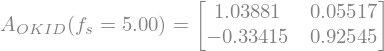

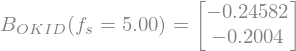

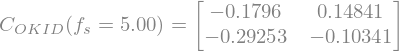

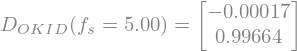

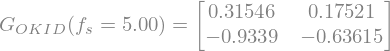

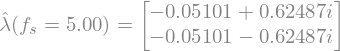

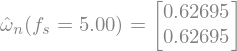

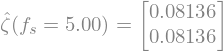

In [4]:
# Simulation
for i in range(cases):
    X_sim[i], Z_sim[i] = sim_ss(A, B, C, D, X_0 = X_0_sim, U = U_sim[i], nt = nt_sim)
    # Sample at lower frequency
    X_sample[i], Z_sample[i] = X_sim[i, :, ::interval], Z_sim[i, :, ::interval]
    if i == 0:
        # Split between train and test data for case 1
        X_train, Z_train = X_sample[i, :, :train_cutoff], Z_sample[i, :, :train_cutoff]
        # Identify System Markov parameters and Observer Gain Markov parameters
        Y_okid, Y_og_okid = okid(Z_train, U_train,
                                 l_0 = order, alpha = alpha, beta = beta, n = n_era)
        # Identify state space model using System Markov parameters for ERA
        A_okid, B_okid, C_okid, D_okid, S_okid = \
            era(Y_okid, alpha = alpha, beta = beta, n = n_era)
        # Construct observability matrix
        O_p_okid = np.array([C_okid @ np.linalg.matrix_power(A_okid, i)
                             for i in range(order)])
        G_okid = spla.pinv2(O_p_okid.reshape([order*m, n_era])) @ Y_og_okid.reshape([order*m, m])
        X_okid_train, Z_okid_train = sim_ss(A_okid, B_okid, C_okid, D_okid,
                                            X_0 = X_0_okid, U = U_train, nt = nt_train)
        # Display outputs
        etch(f"A_{{OKID}}(f_s = {1/dt_sample:0.2f})", A_okid)
        etch(f"B_{{OKID}}(f_s = {1/dt_sample:0.2f})", B_okid)
        etch(f"C_{{OKID}}(f_s = {1/dt_sample:0.2f})", C_okid)
        etch(f"D_{{OKID}}(f_s = {1/dt_sample:0.2f})", D_okid)
        etch(f"G_{{OKID}}(f_s = {1/dt_sample:0.2f})", G_okid)
        # Calculate and display eigenvalues
        eig_A_okid = spla.eig(d2c(A_okid, B_okid, dt_sample)[0])[0] # Eigenvalues of identified system
        etch(f"\hat{{\lambda}}(f_s = {1/dt_sample:0.2f})", eig_A_okid)
        etch(f"\hat{{\omega}}_{{n}}(f_s = {1/dt_sample:0.2f})", np.abs(eig_A_okid))
        etch(f"\hat{{\zeta}}(f_s = {1/dt_sample:0.2f})", -np.cos(np.angle(eig_A_okid)))
    X_test[i], Z_test[i] = X_sample[i], Z_sample[i]
    X_okid_test[i], Z_okid_test[i] = sim_ss(A_okid, B_okid, C_okid, D_okid,
                                            X_0 = X_0_okid, U = U_test[i], nt = nt_test)

There is significant error in the eigenvalues
found with half the sampling frequency as
the damping ratios and natural frequencies found
are quite different to the actual values.
The identified system has postive damping whereas
the actual system is undamped.
Since the input is random and of positive magnitude at each time step,
losing half of the actual input and output data
means that the estimation fails.

In [5]:
RMS_train = np.sqrt(np.mean((Z_okid_train - Z_train)**2, axis = 1))
print(f"RMS Error of sim. for system found via OKID for train data, sampling frequency = {1/dt_sample:0.2f}: {RMS_train}")
RMS_test = np.zeros([cases, m])
for i in range(cases):
    RMS_test[i] = np.sqrt(np.mean((Z_okid_test[i] - Z_test[i])**2, axis = 1))
    print(f"RMS Error of sim. for system found via OKID for test data, case {i}, sampling frequency = {1/dt_sample:0.2f}: {RMS_test[i]}")

RMS Error of sim. for system found via OKID for train data, sampling frequency = 5.00: [0.08864623 0.03289382]
RMS Error of sim. for system found via OKID for test data, case 0, sampling frequency = 5.00: [0.3594864  0.10440578]
RMS Error of sim. for system found via OKID for test data, case 1, sampling frequency = 5.00: [6.61659491 1.80628444]
RMS Error of sim. for system found via OKID for test data, case 2, sampling frequency = 5.00: [0.12583541 0.05357434]


The RMS error in the estimation is quite high
for both the training and testing data.
The training cases have input of relatively high frequencies,
again contributing to the poor accuracy of the identified system
as it cannot cope with this.

In [6]:
# Eigenvalue plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Eigenvalues\nSampling Frequency = {1/dt_sample:0.2f} Hz", fontweight = "bold")

ax.plot(np.real(eig_A), np.imag(eig_A),
         "o", mfc = "None")
ax.plot(np.real(eig_A_okid), np.imag(eig_A_okid),
         "s", mfc = "None")

fig.legend(labels = ("True", "OKID"),
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"midterm_{prob}_eigval_dt{b}.pdf",
            dpi = 80, bbox_inches = "tight")

# Singular Value plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Singular Values\nSampling Frequency = {1/dt_sample:0.2f} Hz", fontweight = "bold")

ax.plot(np.linspace(1, len(S_okid), len(S_okid)), S_okid,
         "o", mfc = "None")
plt.setp(ax, xlabel = f"Singular Value", ylabel = f"Value",
         xticks = np.arange(1, len(S_okid) + 1))

fig.savefig(figs_dir / f"midterm_{prob}_singval_dt{b}.pdf",
            dpi = 80, bbox_inches = "tight")

# Response plots
ms = 0.5 # Marker size
for i in range(cases):
    fig, axs = plt.subplots(1 + n, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] State Responses (Case {i + 1})\nSampling Frequency = {1/dt_sample:0.2f} Hz",
                 fontweight = "bold")

    if i == 0:
        axs[i].plot(t_sim[:-1], U_sim[i, 0])
        axs[i].plot(t_train, U_train[0],
                    "o", ms = ms, mfc = "None")
        axs[i].plot(t_test[train_cutoff:-1], U_test[i, 0, train_cutoff:],
                    "s", ms = ms, mfc = "None")
        plt.setp(axs[i], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_train, X_train[j],
                            "o", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test[train_cutoff:], X_test[i, j, train_cutoff:],
                            "s", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ("True", "Train", "Test"),
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        axs[0].plot(t_sim[:-1], U_sim[i, 0])
        axs[0].plot(t_test[:-1], U_test[i, 0],
                    "o", ms = ms, mfc = "None")
        plt.setp(axs[0], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_test, X_test[i, j],
                            "o", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ("True", "Test"),
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_states_case{i + 1}_dt{b}.pdf",
                dpi = 80, bbox_inches = "tight")

# Observation plots
for i in range(cases):
    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Observation Responses (Case {i + 1})\nSampling Frequency = {1/dt_sample:0.2f} Hz",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_train, Z_train[j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_test[i, j, train_cutoff:],
                        "s", ms = ms, mfc = "None")
            axs[j].plot(t_train, Z_okid_train[j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_okid_test[i, j, train_cutoff:],
                        "D", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Train", "Test",
                             "OKID\n(Train)", "OKID\n(Test)"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_test[:-1], Z_test[i, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[:-1], Z_okid_test[i, j],
                        "s", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Test", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_obs_case{i + 1}_dt{b}.pdf",
                dpi = 80, bbox_inches = "tight")

    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Observation Error (Case {i + 1})\nSampling Frequency = {1/dt_sample:0.2f} Hz",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_train, np.abs(Z_okid_train[j] - Z_train[j]),
                        c = "C1")
            axs[j].plot(t_test[train_cutoff:-1], np.abs(Z_okid_test[i, j, train_cutoff:] - Z_test[i, j, train_cutoff:]),
                        "o", ms = ms, mfc = "None", c = "C0")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["OKID\nTrain", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_test[:-1], np.abs(Z_okid_test[i, j] - Z_test[i, j]),
                        "o", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_obs-error_case{i + 1}_dt{b}.pdf",
                dpi = 80, bbox_inches = "tight")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

On the whole, the estimation is quite poor in this case
due to the loss of half of all the random input
and the corresponding output data. Due to this reason,
decreasing the sample frequency significantly worsened the accuracy of the
estimation. For a simpler training dataset where the input was more uniform
and less random, the estimation accuracy for lower sampling frequencies may
have been slightly improved.